<a href="https://colab.research.google.com/github/vadManuel/Machine-Learning-UCF/blob/master/Homework/hw2/mvasquez_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

TensorFlow 2.x selected.


In [0]:
#@title Theme Function (double-click for code) { display-mode: "form" }
def theme(color='light'):
  rc_params = None
  fontdict = None
  if color is 'dark':
    rc_params = {'ytick.color':'w',
          'xtick.color':'w',
          'axes.labelcolor':'w',
          'axes.edgecolor':'w'}
    fontdict = {'color':'w'}
  else:
    rc_params = {'ytick.color' : 'k',
          'xtick.color' : 'k',
          'axes.labelcolor' : 'k',
          'axes.edgecolor' : 'k'}
    fontdict = {'color':'k'}
  return rc_params, fontdict


In [0]:
"""
Uncomment if using dark theme in colab
"""
rc_params, fontdict = theme('light')
# rc_params, fontdict = theme('dark')

## Problem 2

Modify the network architecture in this notebook for classifying MNIST fashion items with dense layers and analyzing model performance by varying the number of hidden layers and choosing different sizes for the hidden layers.

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
all_images = np.concatenate((train_images,test_images))
fl = all_images.reshape(all_images.shape[0], -1).astype('float32')
fl /= np.max(fl)

X_train = fl[:60000]
X_test  = fl[60000:]

In [0]:
#@title EarlyStopping Class Implementation (double-click for code) { display-mode: "form" }
# Source: https://www.tensorflow.org/guide/keras/custom_callback#early_stopping_at_minimum_loss

class EarlyStopping(keras.callbacks.Callback):
  """
  Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
    patience: Number of epochs to wait after min has been hit. After this
    number of no improvement, training stops.
  """

  def __init__(self, patience=0, metric='val_loss'):
    super(EarlyStopping, self).__init__()

    self.patience = patience
    self.metric = metric

    # best_weights to store the weights at which the minimum loss occurs.
    self.best_weights = None

  def on_train_begin(self, logs=None):
    # The number of epoch it has waited when loss is no longer minimum.
    self.wait = 0
    # The epoch the training stops at.
    self.stopped_epoch = 0
    # Initialize the best as infinity.
    self.best = np.Inf

  def on_epoch_end(self, epoch, logs=None):
    current = None
    if self.metric == 'just right':
      train_loss = logs.get('loss')
      val_loss = logs.get('val_loss')
      current = abs(train_loss-val_loss)
    else:
      current = logs.get(self.metric)

    if np.less(current, self.best):
      self.best = current
      self.wait = 0
      # Record the best weights if current results is better (less).
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
    if self.wait >= self.patience:
      self.stopped_epoch = epoch
      self.model.stop_training = True
      self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print('Epoch %d: early stopping (best epoch %d)' % (self.stopped_epoch+1, self.stopped_epoch+1-self.patience))

## Model Parameters

In [0]:
model_get_params = {'optimizer':keras.optimizers.Adam}
model_fit_params = {'x':X_train, 'y':train_labels,
                    'validation_data':(X_test,test_labels),
                    'callbacks':[EarlyStopping(patience=3)]}
model_eval_params = {'x':X_test, 'y':test_labels, 'verbose':0}

## Models

In [0]:
def get_under_fitting_model(optimizer=None, lr=None, input_shape=(784,)):
  opt = optimizer(lr=lr)

  model = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=input_shape),
    keras.layers.Dropout(.2),
    keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

def get_over_fitting_model(optimizer=None, lr=None, input_shape=(784,)):
  opt = optimizer(lr=lr)

  model = keras.Sequential([
    keras.layers.Dense(1024, activation='relu', input_shape=input_shape),
    keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

def get_just_right_model(optimizer=None, lr=None, input_shape=(784,)):
  opt = optimizer(lr=lr)

  model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    keras.layers.Dropout(.2),
    keras.layers.Dense(64, activation='relu', input_shape=input_shape),
    keras.layers.Dropout(.2),
    keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

## Fitting Models

In [9]:
epochs = 20

ts = ['Under-fitting Model', 'Over-fitting Model', 'Just Right Model']
models = [
  get_under_fitting_model(**model_get_params, lr=.001),
  get_over_fitting_model(**model_get_params, lr=.001),
  get_just_right_model(**model_get_params, lr=.001)
]
histories = []

for i in range(len(models)):
  print('%s training' % ts[i])
  histories.append(models[i].fit(**model_fit_params, epochs=epochs, verbose=1))
  evaluation = models[i].evaluate(**model_eval_params)
  print('%s\nValidation - Loss:%.4f Accuracy:%.4f\n%s' % ('*'*40,evaluation[0],evaluation[1],'*'*40))

Under-fitting Model training
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 70us/sample - loss: 0.8744 - accuracy: 0.6811 - val_loss: 0.5564 - val_accuracy: 0.8078
Epoch 2/20
60000/60000 [==============================] - 4s 62us/sample - loss: 0.6660 - accuracy: 0.7539 - val_loss: 0.5052 - val_accuracy: 0.8235
Epoch 3/20
60000/60000 [==============================] - 4s 62us/sample - loss: 0.6359 - accuracy: 0.7651 - val_loss: 0.5008 - val_accuracy: 0.8237
Epoch 4/20
60000/60000 [==============================] - 4s 61us/sample - loss: 0.6165 - accuracy: 0.7759 - val_loss: 0.4818 - val_accuracy: 0.8306
Epoch 5/20
60000/60000 [==============================] - 4s 62us/sample - loss: 0.6085 - accuracy: 0.7774 - val_loss: 0.4799 - val_accuracy: 0.8285
Epoch 6/20
60000/60000 [==============================] - 4s 62us/sample - loss: 0.5986 - accuracy: 0.7820 - val_loss: 0.4879 - val_accuracy: 0.8293
Epoch 7/20
60000/60000 [===

In [0]:
#@title Display Accuracy and Loss Graphs (double-click for code) { display-mode: "form" }
def graph(history, t):
  history_dict = history.history

  train_loss = history_dict['loss']
  train_acc = history_dict['accuracy']
  val_loss = history_dict['val_loss']
  val_acc = history_dict['val_accuracy']

  epochs_range = range(1, len(train_loss)+1)

  fig, ax = plt.subplots(1,2)
  fig.subplots_adjust(left=0,right=1.5,wspace=.25)
  fig.suptitle(t, fontdict=fontdict, fontsize=16, x=.75)

  ax[0].plot(epochs_range, train_acc, 'r', label='Training Accuracy')
  ax[0].plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
  ax[0].set_title('Accuracy', fontdict=fontdict)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  ax[1].plot(epochs_range, train_loss, 'r', label='Training Loss')
  ax[1].plot(epochs_range, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Loss', fontdict=fontdict)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

  return fig

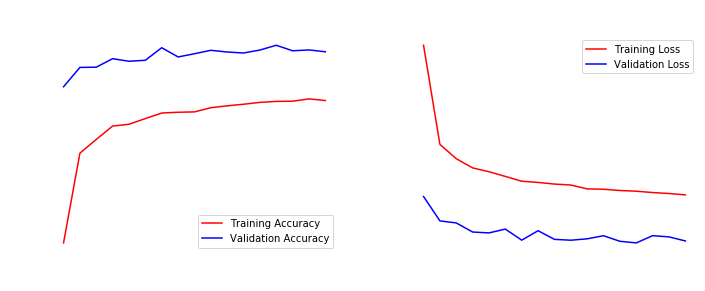

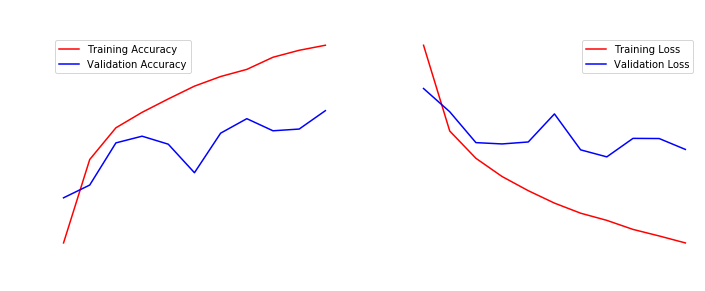

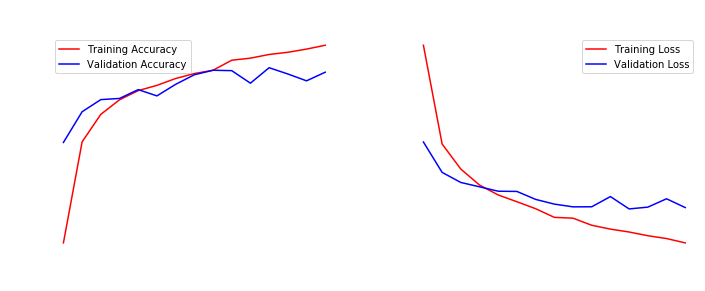

In [11]:
plt.rcParams.update(**rc_params)
for history,t in zip(histories, ts):
  fig = graph(history,t)

plt.show()

In [1]:
all_labels = np.concatenate((train_labels, test_labels))
bad_predictions = []
for model, t in zip(models, ts):
  temp = np.argmax(model.predict(fl), axis=1)
  temp = np.where((temp != all_labels))
  temp = np.reshape(temp, (-1))
  print('%s bad predictions:\t%5d/%d' % (t, len(temp),70000))
  bad_predictions.append(temp)


NameError: ignored